In [85]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Dense, LSTM, GRU, Embedding, BatchNormalization
import re
import string
import datetime
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')
from nltk.translate.bleu_score import sentence_bleu

In [2]:
f = open('ita.txt', encoding='UTF-8', mode='r')
data = f.readlines()
f.close()

In [3]:
data[:5]

['Hi.\tCiao!\tCC-BY 2.0 (France) Attribution: tatoeba.org #538123 (CM) & #607364 (Cero)\n',
 'Run!\tCorri!\tCC-BY 2.0 (France) Attribution: tatoeba.org #906328 (papabear) & #906347 (Guybrush88)\n',
 'Run!\tCorra!\tCC-BY 2.0 (France) Attribution: tatoeba.org #906328 (papabear) & #906348 (Guybrush88)\n',
 'Run!\tCorrete!\tCC-BY 2.0 (France) Attribution: tatoeba.org #906328 (papabear) & #906350 (Guybrush88)\n',
 'Who?\tChi?\tCC-BY 2.0 (France) Attribution: tatoeba.org #2083030 (CK) & #2126402 (Guybrush88)\n']

In [4]:
data[-3:]

["If someone who doesn't know your background says that you sound like a native speaker, it means they probably noticed something about your speaking that made them realize you weren't a native speaker. In other words, you don't really sound like a native speaker.\tSe qualcuno che non conosce il tuo background dice che sembri un madrelingua, significa che probabilmente ha notato qualcosa sul tuo modo di parlare che ha fatto capire che non eri un madrelingua. In altre parole, non sembri davvero un madrelingua.\tCC-BY 2.0 (France) Attribution: tatoeba.org #953936 (CK) & #6473513 (Guybrush88)\n",
 "Doubtless there exists in this world precisely the right woman for any given man to marry and vice versa; but when you consider that a human being has the opportunity of being acquainted with only a few hundred people, and out of the few hundred that there are but a dozen or less whom he knows intimately, and out of the dozen, one or two friends at most, it will easily be seen, when we remember

# Getting Structured Data

In [5]:
def decontractions(phrase):
    '''Performs decontractions in the doc'''

    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)
    phrase = re.sub(r"couldn\'t", "could not", phrase)
    phrase = re.sub(r"shouldn\'t", "should not", phrase)
    phrase = re.sub(r"wouldn\'t", "would not", phrase)
    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
        
    return phrase

def preprocess(data):
    '''Function does simple preprocessing steps such as converting to lowercase, removing punctuations and
       separating the english and italian sentences'''
    english = []
    italian = []
    
    for line in data:
        line = ''.join(e for e in line if e.isdigit() == False)
        line = re.sub(' +', ' ', line)
        line = line.lower()
        line = decontractions(line)
        temp1 = []
        for char in line:
            if char in string.punctuation:
                continue
            else:
                temp1.append(char)
        # removing links
        if re.findall(r'\w+:\/{2}[\d\w-]+(\.[\d\w-]+)*(?:(?:\/[^\s/]*))*', line):
            line = re.sub(r'\w+:\/{2}[\d\w-]+(\.[\d\w-]+)*(?:(?:\/[^\s/]*))*', '', line)
        # removing html if any
        if re.findall('<.*?>',line):
            line = re.sub('<.*?>','',line)
        eng_ita = ''.join(e for e in temp1).split('\t')[:2]
        english.append(eng_ita[0])
        italian.append(eng_ita[1])
    
   # english = decontractions(english)
   # italian = decontractions(italian)
    data = pd.DataFrame()
    data['Italian'] = italian
    data['English'] = english
    
    return data

In [6]:
dataset = preprocess(data)

In [7]:
dataset.tail()

,Italian,English
340427,se vuoi sembrare un madrelingua devi essere di...,if you want to sound like a native speaker you...
340428,se vuoi sembrare un madrelingua devi essere di...,if you want to sound like a native speaker you...
340429,se qualcuno che non conosce il tuo background ...,if someone who does not know your background s...
340430,senza dubbio esiste in questo mondo proprio la...,doubtless there exists in this world precisely...
340431,senza dubbio esiste in questo mondo proprio la...,doubtless there exists in this world precisely...


In [8]:
dataset.shape

(340432, 2)

# EDA

In [9]:
# dropping duplicates
dataset = dataset.drop_duplicates(ignore_index=True)
dataset.shape

(337561, 2)

In [10]:
def eda(data, diagram=True):
    english = data['English'].values
    italian = data['Italian'].values
    
    eng_lengths = []
    ita_lengths = []
    for line in english:
        eng_lengths.append(len(line.split()))
    for line in italian:
        ita_lengths.append(len(line.split()))
    if diagram == True:
        plt.figure(figsize=(10,5))
        plt.subplot(121)
        plt.xlabel('Total Sentences')
        plt.ylabel('Length of each Sentence')
        sns.scatterplot(range(len(english)), eng_lengths)
        plt.subplot(122)
        plt.xlabel('Total Sentences')
        plt.ylabel('Length of each Sentence')
        sns.scatterplot(range(len(italian)), ita_lengths)
    
    print("Max Length of sentences in English: ", max(eng_lengths))
    print("Max Length of sentences in Italian: ", max(ita_lengths))
    
    return eng_lengths,ita_lengths

Max Length of sentences in English:  101
Max Length of sentences in Italian:  92


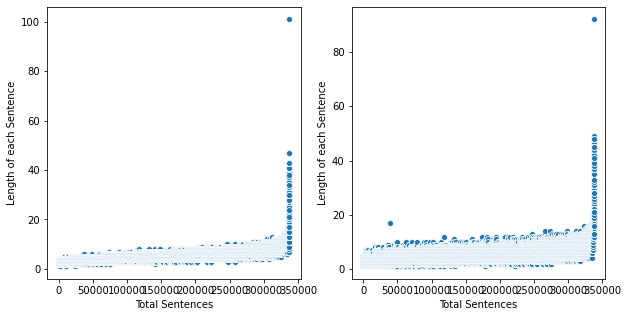

In [11]:
eng_lengths, ita_lengths = eda(dataset)

The length which is the maximum among the english and italian sentences are 101 and 92 respectively, but there is only one datapoint which has that length and the rest of the sentences do not have such a large length. Therefore we can drop that data point from the dataset and work with the rest.

In [12]:
np.argmax(eng_lengths), np.argmax(ita_lengths)

(337559, 337559)

In [13]:
dataset.tail()

,Italian,English
337556,se vuoi sembrare un madrelingua devi essere di...,if you want to sound like a native speaker you...
337557,se vuoi sembrare un madrelingua devi essere di...,if you want to sound like a native speaker you...
337558,se qualcuno che non conosce il tuo background ...,if someone who does not know your background s...
337559,senza dubbio esiste in questo mondo proprio la...,doubtless there exists in this world precisely...
337560,senza dubbio esiste in questo mondo proprio la...,doubtless there exists in this world precisely...


In [14]:
dataset = dataset.iloc[:-2]

Max Length of sentences in English:  47
Max Length of sentences in Italian:  49


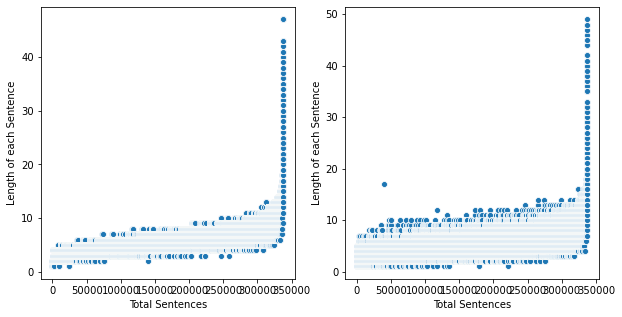

In [15]:
eng_lengths, ita_lengths = eda(dataset, True)

In [31]:
enc_inp_length = 47
dec_inp_length = 49

<AxesSubplot:title={'center':'Difference in Length of sentences'}, xlabel='Number of Sentences', ylabel='Difference'>

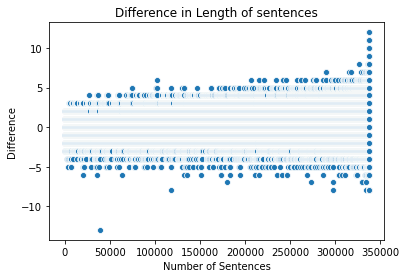

In [17]:
diff_in_lengths = np.array(eng_lengths) - np.array(ita_lengths)
plt.title('Difference in Length of sentences')
plt.ylabel('Difference')
plt.xlabel('Number of Sentences')
sns.scatterplot(range(len(eng_lengths)), diff_in_lengths)

Sometimes English sentences tend to be longer whereas sometimes Italian sentences tend to be longer. There is no such theory that one language will always have longer sentences.

In [18]:
def modify(text):
    a = 'startseq' + ' ' + text + ' ' + 'endseq'
    return a

In [19]:
#dataset['English'] = dataset['English'].apply(lambda x: modify(x))
dataset['Italian'] = dataset['Italian'].apply(lambda x: modify(x))

In [20]:
dataset.head()

,Italian,English
0,startseq ciao endseq,hi
1,startseq corri endseq,run
2,startseq corra endseq,run
3,startseq correte endseq,run
4,startseq chi endseq,who


# Preprocesing

In [21]:
X_train, X_test, y_train, y_test = train_test_split(dataset['English'], dataset['Italian'], test_size = 0.2, 
                                                           random_state=141)

In [27]:
X_train, X_cv, y_train, y_cv = train_test_split(dataset['English'], dataset['Italian'], test_size=0.1, 
                                                   random_state =23)
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.05, 
                                                   random_state =23)

In [28]:
X_train.shape, X_test.shape, X_cv.shape

((288612,), (15191,), (33756,))

In [29]:
eng_tokenizer = Tokenizer()
eng_tokenizer.fit_on_texts(X_train)

X_train_tok = eng_tokenizer.texts_to_sequences(X_train)
X_cv_tok = ita_tokenizer.texts_to_sequences(X_cv)
X_test_tok = eng_tokenizer.texts_to_sequences(X_test)

In [30]:
ita_tokenizer = Tokenizer()
ita_tokenizer.fit_on_texts(y_train)

y_train_tok = ita_tokenizer.texts_to_sequences(y_train)
y_cv_tok = ita_tokenizer.texts_to_sequences(y_cv)
y_test_tok = ita_tokenizer.texts_to_sequences(y_test)

In [32]:
y_train_pad = pad_sequences(y_train_tok, maxlen = dec_inp_length, padding='post')
y_test_pad = pad_sequences(y_test_tok, maxlen = dec_inp_length, padding='post')
y_cv_pad = pad_sequences(y_cv_tok, maxlen = dec_inp_length, padding='post')

X_train_pad = pad_sequences(X_train_tok, maxlen = enc_inp_length, padding='post')
X_test_pad = pad_sequences(X_test_tok, maxlen = enc_inp_length, padding='post')
X_cv_pad = pad_sequences(X_cv_tok, maxlen = enc_inp_length, padding='post')

In [33]:
X_train_pad.shape, y_train_pad.shape, X_test_pad.shape, y_test_pad.shape

((288612, 47), (288612, 49), (15191, 47), (15191, 49))

In [34]:
#x_vocab = 15001
#y_vocab = 12500

x_vocab = len(eng_tokenizer.word_index.keys()) + 1
y_vocab = len(ita_tokenizer.word_index.keys()) + 1

In [215]:
x_vocab, y_vocab

(12799, 26515)

In [35]:
emb_dim = 64
dec_units = 128
enc_units = 128
att_units = 10

In [98]:
import pickle

In [99]:
f = open('GLOVE_VECTORS.pickle','rb')
glove_vector = pickle.load(f)
f.close()

In [100]:
#vocab_size = len(eng_tokenizer.word_index.keys()) + 1
embedding_matrix = np.zeros((x_vocab,300))
for word, i in eng_tokenizer.word_index.items():
    if word in glove_vector.keys():
        vec = glove_vector[word]
        embedding_matrix[i] = vec
    else:
        continue

# Model 1 - Concat

In [135]:
class Encoder(tf.keras.layers.Layer):
    def __init__(self, vocab_size, embedding_dim, input_length, enc_units):
        super(Encoder, self).__init__()
        self.vocab_size = vocab_size
        self.embedding_dim = embedding_dim
        self.input_length = input_length
        self.enc_units= enc_units
        self.gru_output = 0
        self.state_h=0
        
    def build(self, input_shape):
        self.embedding = Embedding(input_dim=self.vocab_size, output_dim=64, input_length=self.input_length,
                                   mask_zero=True, name="embedding_layer_encoder")
        self.gru = GRU(self.enc_units, return_state=True, return_sequences=True, name="Encoder_GRU")
        
    def call(self, input_sentences, training=True):
        
        input_embed = self.embedding(input_sentences)
        
        self.gru_output, self.gru_state_h = self.gru(input_embed)
        
        return self.gru_output, self.gru_state_h
    
    def get_states(self):
        
        return self.state_h

In [136]:
class OneStepDecoder(tf.keras.layers.Layer):
    def __init__(self, vocab_size, emb_dim, att_units, dec_units):
        super(OneStepDecoder, self).__init__()
        self.vocab_size = vocab_size
        self.emb_dim = emb_dim
        self.att_units = att_units
        self.dec_units = dec_units
        
    def build(self, input_shape):
        self.embedding = Embedding(input_dim=self.vocab_size, output_dim=64, input_length=49, mask_zero=True,
                                   name="embedding_layer_decoder")
        self.gru = GRU(self.dec_units, return_sequences=True, return_state=True, name="Decoder_GRU")
        self.fc = Dense(self.vocab_size)
        
        self.V = Dense(1)
        self.W = Dense(self.att_units)
        self.U = Dense(self.att_units)
        
    def call(self, dec_input, hidden_state, enc_output):

        hidden_with_time = tf.expand_dims(hidden_state, 1)
       
        attention_weights = self.V(tf.nn.tanh(self.U(enc_output) + self.W(hidden_with_time)))
        
        attention_weights = tf.nn.softmax(attention_weights, 1)
        
        context_vector = attention_weights * enc_output
        
        context_vector = tf.reduce_sum(context_vector, axis=1)
        

        x = self.embedding(dec_input)
        x = tf.concat([tf.expand_dims(context_vector, axis=1),x], axis=-1)
        output, h_state = self.gru(x, initial_state = hidden_state)
        
        output = tf.reshape(output, (-1, output.shape[2]))
        
        x = self.fc(output)
        
        return x, h_state, attention_weights

In [137]:
class Decoder(tf.keras.layers.Layer):
    
    def __init__(self, embedding_dim, vocab_size, input_length, dec_units, att_units):
        super(Decoder, self).__init__()
        self.vocab_size = vocab_size
        self.embedding_dim = embedding_dim
        self.input_length = input_length
        self.dec_units = dec_units
        self.att_units = att_units
        self.onestep_decoder = OneStepDecoder(self.vocab_size, self.embedding_dim, self.att_units, self.dec_units)
    @tf.function    
    def call(self, dec_input, hidden_state, enc_output):
        all_outputs = tf.TensorArray(tf.float32, dec_input.shape[1], name='output_arrays')
        
        for timestep in range(dec_input.shape[1]):
            
            output, hidden_state, attention_weights = self.onestep_decoder(dec_input[:, timestep:timestep+1], 
                                                                           hidden_state, enc_output)
            
            all_outputs = all_outputs.write(timestep, output)
            
        all_outputs = tf.transpose(all_outputs.stack(), [1,0,2])
        return all_outputs

In [138]:
class Attention_Model(tf.keras.Model):
    def __init__(self, embedding_dim, x_vocab, y_vocab, dec_units, enc_units, enc_inp_length, dec_inp_length, att_units):
        super(Attention_Model, self).__init__()
        self.encoder = Encoder(x_vocab, embedding_dim, enc_inp_length, enc_units)
        self.decoder = Decoder(embedding_dim, y_vocab, dec_inp_length,dec_units, att_units)
        
    def call(self, data):
        enc_input, dec_input = data[0], data[1]
    
        enc_output, enc_state = self.encoder(enc_input)
    
        dec_output = self.decoder(dec_input, enc_state, enc_output)

        return dec_output

In [139]:
model1 = Attention_Model(emb_dim, x_vocab, y_vocab, dec_units, enc_units, enc_inp_length, dec_inp_length, att_units)

In [140]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
loss_function = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='auto')

def maskedLoss(y_true, y_pred):
    #getting mask value
    mask = tf.math.logical_not(tf.math.equal(y_true, 0))
    
    #calculating the loss
    loss_ = loss_function(y_true, y_pred)
    
    #converting mask dtype to loss_ dtype
    mask = tf.cast(mask, dtype=loss_.dtype)
    
    #applying the mask to loss
    loss_ = loss_*mask
    
    #getting mean over all the values
    loss_ = tf.reduce_mean(loss_)
    return loss_

In [141]:
model1.compile(optimizer=optimizer, loss=maskedLoss)

In [142]:
log_dir="Eng_Ita\Tensorboard\logs_m2\\fit1\\" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir,histogram_freq=1, write_graph=True)

checkpoint = tf.keras.callbacks.ModelCheckpoint('Eng_Ita/Weights/model_log_m2_fit1_{epoch:02d}.h5',
                                                save_weights_only=True)

In [47]:
model1.fit([X_train_pad, y_train_pad[:,:-1]], y_train_pad[:,1:], 
           validation_data=([X_test_pad, y_test_pad[:,:-1]], y_test_pad[:,1:]),
           epochs=10, callbacks=[tensorboard_callback, checkpoint])

Train on 288612 samples, validate on 15191 samples
Epoch 1/10
288612/288612 [==============================] - 2000s 7ms/sample - loss: 0.0688 - val_loss: 0.0391
Epoch 2/10
288612/288612 [==============================] - 1948s 7ms/sample - loss: 0.0301 - val_loss: 0.0246
Epoch 3/10
288612/288612 [==============================] - 1982s 7ms/sample - loss: 0.0204 - val_loss: 0.0199
Epoch 4/10
288612/288612 [==============================] - 1938s 7ms/sample - loss: 0.0163 - val_loss: 0.0179
Epoch 5/10
288612/288612 [==============================] - 1956s 7ms/sample - loss: 0.0139 - val_loss: 0.0167
Epoch 6/10
288612/288612 [==============================] - 1937s 7ms/sample - loss: 0.0124 - val_loss: 0.0160
Epoch 7/10
288612/288612 [==============================] - 1939s 7ms/sample - loss: 0.0113 - val_loss: 0.0155
Epoch 8/10
288612/288612 [==============================] - 1940s 7ms/sample - loss: 0.0106 - val_loss: 0.0152
Epoch 9/10
288612/288612 [==============================] - 1

In [178]:
#model1.save_weights('Eng_Ita/Weights/model_log_m1_fit2_10.h5')

In [179]:
def inference_concat(inputs):
    
    in_ = len(inputs.split()) - 1
    #print(in_)
    inputs = [inputs]
    inputs = np.array(eng_tokenizer.texts_to_sequences(inputs))
    inputs = pad_sequences(inputs, enc_inp_length, padding='post')
    #print('padding: ', inputs.shape)
    enc_output, enc_state = model1.layers[0](inputs)
    input_state = enc_state
    pred = []
    cur_vec = np.array([ita_tokenizer.word_index['startseq']]).reshape(-1,1)
    att_weights = np.zeros((in_, dec_inp_length))
    for i in range(49):

        inf_output, input_state, attention_weights = model1.layers[1].onestep_decoder(cur_vec, input_state, enc_output)
        #print(attention_weights[0][:,0].shape)
        cur_vec = np.reshape(np.argmax(inf_output), (1, 1))
        if cur_vec[0][0] != 0:
            pred.append(cur_vec)
            att_weights[:,i] = attention_weights[0][:in_,0]
        else:
            break
    att_weights = att_weights[:,:len(pred)]
    final = ' '.join([ita_tokenizer.index_word[e[0][0]] for e in pred if e[0][0] != 0 and e[0][0] != 2])
    return final, att_weights

## Example 1

In [180]:
print('english Sentence: ', X_test.iloc[576])

english Sentence:  i polished my shoes


In [181]:
pred, att_weights = inference_concat(X_test.values[576])

In [182]:
print('Predicted: ',pred)
print('Original: ', y_test.values[576])

Predicted:  mi sono sempre lavata i denti
Original:  startseq ho lucidato le mie scarpe endseq


<AxesSubplot:>

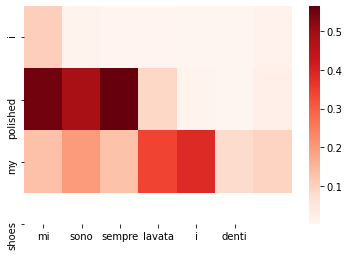

In [157]:
sns.heatmap(att_weights, cmap='Reds', xticklabels=pred.split(), yticklabels=X_test.values[576].split())

The inference function returns the sentence without the last 'endseq' token. That is the reason the last unit do not contain a word.

## Example 2

In [184]:
print('English Sentence: ', X_test.iloc[316])

English Sentence:  why are not you wearing your gloves


In [185]:
pred1, att_weights1 = inference_concat(X_test.values[316])

In [186]:
print('Predicted: ',pred1, '\n')
print('Original: ', y_test.values[316])

Predicted:  perché non stai indossando i suoi guanti 

Original:  startseq perché non sta indossando i suoi guanti endseq


In [118]:
# emb
print('Predicted: ',pred1, '\n')
print('Original: ', y_test.values[316])

Predicted:  perché non stai indossando le sue guanti 

Original:  startseq perché non sta indossando i suoi guanti endseq


In [64]:
print('Predicted: ',pred1, '\n')
print('Original: ', y_test.values[316])

Predicted:  perché non stai indossando i vostri guanti 

Original:  startseq perché non sta indossando i suoi guanti endseq


<AxesSubplot:>

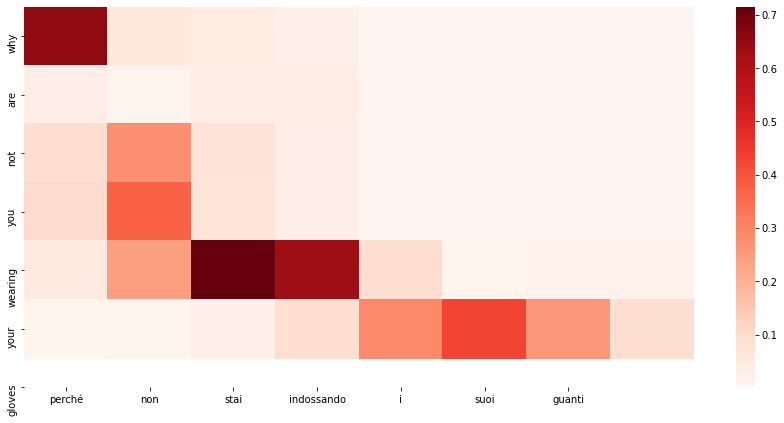

In [187]:
plt.figure(figsize=(15,7))
sns.heatmap(att_weights1, cmap='Reds', xticklabels=pred1.split(), yticklabels=X_test.values[316].split())

# Example 3

In [191]:
print('english Sentence: ', X_test.iloc[1235])

english Sentence:  i am not mad at tom anymore


In [192]:
pred, att_weights = inference_concat(X_test.values[1235])

In [193]:
print('Predicted: ',pred)
print('Original: ', y_test.values[1235])

Predicted:  io non sono più arrabbiato con tom
Original:  startseq non sono più arrabbiata con tom endseq


<AxesSubplot:>

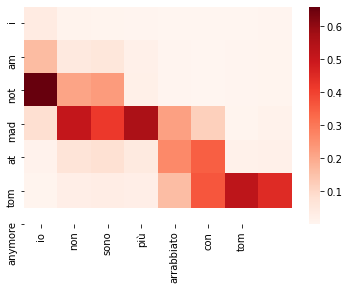

In [195]:
sns.heatmap(att_weights, cmap='Reds', xticklabels=pred.split(), yticklabels=X_test.values[1235].split())

# Example 4

In [204]:
print('english Sentence: ', X_test.iloc[13298])

english Sentence:  since there are usually multiple websites on any given topic i usually just click the back button when i arrive on any webpage that has popup advertising i just go to the next page found by google and hope for something less irritating


In [205]:
pred, att_weights = inference_concat(X_test.values[13298])

In [206]:
print('Predicted: ',pred)
print('Original: ', y_test.values[13298])

Predicted:  dato che solitamente ci sono molti siti web su qualunque dato argomento di solito clicco sul pulsante indietro e basta quando arrivo su qualunque pagina web che ha della pubblicità a popup semplicemente vado sulla pagina successiva trovata da google e spero di trovare qualcosa di meno
Original:  startseq dato che di solito ci sono molti siti web su qualsiasi dato argomento solitamente clicco sul pulsante indietro e basta quando arrivo su qualunque pagina web che ha della pubblicità a popup semplicemente vado sulla pagina successiva trovata da google e spero di trovare qualcosa di meno irritante endseq


<AxesSubplot:>

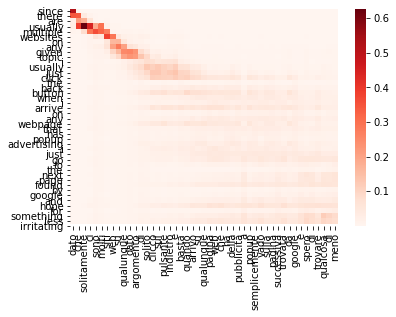

In [207]:
sns.heatmap(att_weights, cmap='Reds', xticklabels=pred.split(), yticklabels=X_test.values[13298].split())

### ------------------------------------------------------------------------------

In [201]:
temp = []
for i in X_test.values:
    temp.append(len(i.split()))

In [203]:
np.argmax(temp)

13298

## BLEU Evaluation on 3000 number of data points

In [208]:
def bleu(X_test, y_test):
    bleu1 = []
    bleu2 = []
    bleu3 = []
    bleu4 = []
    for x, y in zip(X_test.values, y_test.values):

        pred_y, attention_weights = inference_concat(x)
        
        y = ' '.join(e for e in y.split()[1:-1])  # removes the start and end token

        bleu1.append(sentence_bleu([y.split()], pred_y.split(), weights = (1,0,0,0)))
        bleu2.append(sentence_bleu([y.split()], pred_y.split(), weights = (0.5,0.5,0,0)))
        bleu3.append(sentence_bleu([y.split()], pred_y.split(), weights = (0.33,0.33,0.33,0)))
        bleu4.append(sentence_bleu([y.split()], pred_y.split(), weights = (0.25,0.25,0.25,0.25)))
        
    return bleu1, bleu2, bleu3, bleu4

In [209]:
b1, b2, b3, b4 = bleu(X_test.iloc[:3000], y_test.iloc[:3000])

In [210]:
# epoch 10
print('Bleu1 Score: ', sum(b1)/3000)
print('Bleu2 Score: ', sum(b2)/3000)
print('Bleu3 Score: ', sum(b3)/3000)
print('Bleu4 Score: ', sum(b4)/3000)

Bleu1 Score:  0.6436630341533273
Bleu2 Score:  0.5224439090543285
Bleu3 Score:  0.3913146896726426
Bleu4 Score:  0.27410915259156676


In [96]:
# epoch 8
print('Bleu1 Score: ', sum(b1)/3000)
print('Bleu2 Score: ', sum(b2)/3000)
print('Bleu3 Score: ', sum(b3)/3000)
print('Bleu4 Score: ', sum(b4)/3000)

Bleu1 Score:  0.6736233417219999
Bleu2 Score:  0.5555658502317086
Bleu3 Score:  0.4230974308128043
Bleu4 Score:  0.308340964229032
